In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from collections import Counter
from numpy import mean
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.svm import SVC


warnings.filterwarnings('ignore')

# 0. usefull functions

In [2]:
def plot_histograms( df , variables , n_rows , n_cols ):
    fig = plt.figure( figsize = ( 16 , 12 ) )
    for i, var_name in enumerate( variables ):
        ax=fig.add_subplot( n_rows , n_cols , i+1 )
        df[ var_name ].hist( bins=10 , ax=ax )
        ax.set_title( 'Skew: ' + str( round( float( df[ var_name ].skew() ) , ) ) ) # + ' ' + var_name ) #var_name+" Distribution")
        ax.set_xticklabels( [] , visible=False )
        ax.set_yticklabels( [] , visible=False )
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()

def plot_correlation_map( df ):
    corr = titanic.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

def describe_more( df ):
    var = [] ; l = [] ; t = []
    for x in df:
        var.append( x )
        l.append( len( pd.value_counts( df[ x ] ) ) )
        t.append( df[ x ].dtypes )
    levels = pd.DataFrame( { 'Variable' : var , 'Levels' : l , 'Datatype' : t } )
    levels.sort_values( by = 'Levels' , inplace = True )
    return levels

def plot_variable_importance( X , y ):
    tree = DecisionTreeClassifier( random_state = 99 )
    tree.fit( X , y )
    plot_model_var_imp( tree , X , y )
    
def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print (model.score( X , y ))

# 1.  découvrir les données

In [3]:
fd = pd.read_csv("Financial Distress.csv")

In [4]:
fd.head()

,Company,Time,Financial Distress,x1,x2,x3,x4,x5,x6,x7,...,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83
0,1,1,0.010636,1.2810,0.022934,0.87454,1.21640,0.060940,0.188270,0.52510,...,85.437,27.07,26.102,16.000,16.0,0.2,22,0.060390,30,49
1,1,2,-0.455970,1.2700,0.006454,0.82067,1.00490,-0.014080,0.181040,0.62288,...,107.090,31.31,30.194,17.000,16.0,0.4,22,0.010636,31,50
2,1,3,-0.325390,1.0529,-0.059379,0.92242,0.72926,0.020476,0.044865,0.43292,...,120.870,36.07,35.273,17.000,15.0,-0.2,22,-0.455970,32,51
3,1,4,-0.566570,1.1131,-0.015229,0.85888,0.80974,0.076037,0.091033,0.67546,...,54.806,39.80,38.377,17.167,16.0,5.6,22,-0.325390,33,52
4,2,1,1.357300,1.0623,0.107020,0.81460,0.83593,0.199960,0.047800,0.74200,...,85.437,27.07,26.102,16.000,16.0,0.2,29,1.251000,7,27


In [5]:
print("le dataset a {} lignes et {} colnnes".format(fd.shape[0],fd.shape[1]))

le dataset a 3672 lignes et 86 colnnes


In [6]:
fd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3672 entries, 0 to 3671
Data columns (total 86 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Company             3672 non-null   int64  
 1   Time                3672 non-null   int64  
 2   Financial Distress  3672 non-null   float64
 3   x1                  3672 non-null   float64
 4   x2                  3672 non-null   float64
 5   x3                  3672 non-null   float64
 6   x4                  3672 non-null   float64
 7   x5                  3672 non-null   float64
 8   x6                  3672 non-null   float64
 9   x7                  3672 non-null   float64
 10  x8                  3672 non-null   float64
 11  x9                  3672 non-null   float64
 12  x10                 3672 non-null   float64
 13  x11                 3672 non-null   float64
 14  x12                 3672 non-null   float64
 15  x13                 3672 non-null   float64
 16  x14   

In [7]:
fd.describe()

,Company,Time,Financial Distress,x1,x2,x3,x4,x5,x6,x7,...,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83
count,3672.000000,3672.000000,3672.000000,3672.000000,3672.000000,3672.000000,3.672000e+03,3672.000000,3672.000000,3672.000000,...,3672.000000,3672.000000,3672.000000,3672.000000,3672.000000,3672.000000,3672.000000,3672.000000,3672.000000,3672.000000
mean,182.084423,7.528322,1.040257,1.387820,0.129706,0.615769,8.681599e-01,0.154949,0.106717,0.784031,...,86.839822,91.920506,89.115908,17.780855,15.198708,-2.664305,19.714597,1.100488,13.122277,33.044935
std,117.024636,4.064016,2.652227,1.452926,0.120013,0.177904,5.719519e-01,0.124904,0.210555,1.033606,...,16.706209,64.656504,64.349382,2.040152,2.828648,8.192663,7.508588,2.666733,9.465907,13.714563
min,1.000000,1.000000,-8.631700,0.075170,-0.258080,0.016135,5.350000e-07,-0.269790,-0.627750,0.035160,...,54.806000,24.318000,23.776000,15.250000,12.000000,-20.200000,1.000000,-0.499220,1.000000,2.000000
25%,80.000000,4.000000,0.172275,0.952145,0.048701,0.501888,5.525575e-01,0.070001,-0.027754,0.436003,...,79.951000,39.800000,38.377000,16.000000,13.000000,-7.000000,14.000000,0.189912,6.000000,21.000000
50%,168.000000,7.000000,0.583805,1.183600,0.107530,0.638690,7.752450e-01,0.131830,0.104325,0.641875,...,90.000000,66.120000,59.471000,17.000000,14.500000,0.200000,20.000000,0.594765,11.000000,34.000000
75%,264.250000,11.000000,1.351750,1.506475,0.188685,0.749425,1.039000e+00,0.219570,0.231230,0.896772,...,93.883000,130.500000,132.400000,20.000000,16.000000,2.100000,26.000000,1.355050,17.000000,44.000000
max,422.000000,14.000000,128.400000,51.954000,0.749410,0.967900,6.835600e+00,0.858540,0.929550,38.836000,...,120.870000,227.500000,214.500000,22.000000,22.000000,8.600000,37.000000,128.400000,49.000000,74.000000


In [8]:
print("le dataset au plus {} valeurs nulles".format(fd.isnull().sum().max()))

le dataset au plus 0 valeurs nulles


In [9]:
print("les colonnes sont : \n", fd.columns)

les colonnes sont : 
 Index(['Company', 'Time', 'Financial Distress', 'x1', 'x2', 'x3', 'x4', 'x5',
       'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16',
       'x17', 'x18', 'x19', 'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26',
       'x27', 'x28', 'x29', 'x30', 'x31', 'x32', 'x33', 'x34', 'x35', 'x36',
       'x37', 'x38', 'x39', 'x40', 'x41', 'x42', 'x43', 'x44', 'x45', 'x46',
       'x47', 'x48', 'x49', 'x50', 'x51', 'x52', 'x53', 'x54', 'x55', 'x56',
       'x57', 'x58', 'x59', 'x60', 'x61', 'x62', 'x63', 'x64', 'x65', 'x66',
       'x67', 'x68', 'x69', 'x70', 'x71', 'x72', 'x73', 'x74', 'x75', 'x76',
       'x77', 'x78', 'x79', 'x80', 'x81', 'x82', 'x83'],
      dtype='object')


# 2. Choix du type d'algorithme 

On va ajouter une colnne binaire qui s'appelle "healthy" qui donne 0 au Company qui sont en sain etat et 1 sinon
et par la suite le probleme sera une <b> CLASSIFICATION </b> <br>
NB : les Company qui ont une Financial Distress > -0.5 seront considérées comme saines

In [10]:

fd['healthy'] = [0 if fd['Financial Distress'][x] > -0.5 else 1 for x in range(3672)]
fd = fd.drop('Financial Distress', axis = 1)

In [11]:
fd.head(5)

,Company,Time,x1,x2,x3,x4,x5,x6,x7,x8,...,x75,x76,x77,x78,x79,x80,x81,x82,x83,healthy
0,1,1,1.2810,0.022934,0.87454,1.21640,0.060940,0.188270,0.52510,0.018854,...,27.07,26.102,16.000,16.0,0.2,22,0.060390,30,49,0
1,1,2,1.2700,0.006454,0.82067,1.00490,-0.014080,0.181040,0.62288,0.006423,...,31.31,30.194,17.000,16.0,0.4,22,0.010636,31,50,0
2,1,3,1.0529,-0.059379,0.92242,0.72926,0.020476,0.044865,0.43292,-0.081423,...,36.07,35.273,17.000,15.0,-0.2,22,-0.455970,32,51,0
3,1,4,1.1131,-0.015229,0.85888,0.80974,0.076037,0.091033,0.67546,-0.018807,...,39.80,38.377,17.167,16.0,5.6,22,-0.325390,33,52,1
4,2,1,1.0623,0.107020,0.81460,0.83593,0.199960,0.047800,0.74200,0.128030,...,27.07,26.102,16.000,16.0,0.2,29,1.251000,7,27,0


# 3. La distrubition de la variable target "healthy"

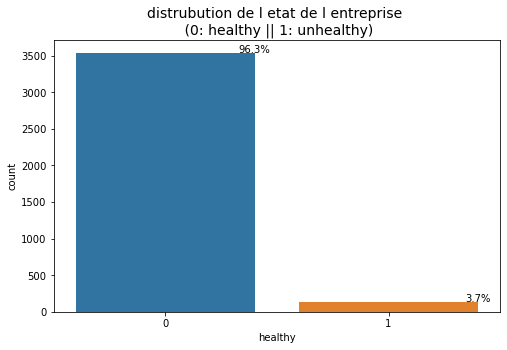

In [12]:
total = float(len(fd))
plt.figure(figsize=(8,5))
ax = sns.countplot(x = 'healthy', data=fd)
plt.title('distrubution de l etat de l entreprise \n (0: healthy || 1: unhealthy)', fontsize=14)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='center')

plt.show()


les données <b> déséquilibrées </b> , la plupart des Company sont en sain etat et le dataset est skewed , donc on va essayer de balancer le dataset mais plutard 

# 4. Etude de correlatrion 

avant toute visualization, on va commencer par eliminer les variables qui portent la meme informations puisque notre jeu de données est immense 

## 4.1 Correlation entre variables

In [13]:
features = fd.drop('healthy', axis = 1)
def top_entries(df):
    mat = df.corr().abs()
    
    # Remove duplicate and identity entries
    mat.loc[:,:] = np.tril(mat.values, k=-1)
    mat = mat[mat>0]

    # Unstack, sort ascending, and reset the index, so features are in columns
    # instead of indexes (allowing e.g. a pretty print in Jupyter).
    # Also rename these it for good measure.
    return (mat.unstack()
             .sort_values(ascending=False)
             .reset_index()
             .rename(columns={
                 "level_0": "feature_a",
                 "level_1": "feature_b",
                 0: "correlation"
             }))
forte_corr = top_entries(features).dropna()
forte_corr = forte_corr[forte_corr['correlation'] >= .7]
forte_corr

,feature_a,feature_b,correlation
0,x23,x50,1.000000
1,x3,x13,1.000000
2,x75,x76,0.997845
3,x16,x52,0.996677
4,x17,x34,0.989344
5,x68,x76,0.980423
6,x14,x49,0.979764
7,x68,x75,0.971307
8,x48,x81,0.965758
9,x32,x38,0.945412


on remarque qu'il ya beaucoup de features qui sont fortement corrélées et par la suite conteint la meme info. on va choisir 0.7 comme seuil d'elimination

In [14]:
var_elim = forte_corr['feature_a']
var_elim = [x for x in var_elim]
var_elim = list(dict.fromkeys(var_elim))
new_df=fd.drop(var_elim, axis = 1)
new_df.head()

,Company,x8,x9,x10,x12,x15,x18,x19,x20,x21,...,x72,x73,x74,x78,x79,x80,x81,x82,x83,healthy
0,1,0.018854,0.182790,0.006449,2.00580,4.6512,0.018265,0.024978,0.027264,1.41730,...,4.0,36.0,85.437,16.0,0.2,22,0.060390,30,49,0
1,1,0.006423,0.035991,0.001795,-0.48644,3.7521,0.027558,0.028804,0.041102,1.18010,...,0.0,36.0,107.090,16.0,0.4,22,0.010636,31,50,0
2,1,-0.081423,-0.765400,-0.054324,0.41220,2.4884,0.012595,0.068116,0.014847,0.81652,...,0.0,35.0,120.870,15.0,-0.2,22,-0.455970,32,51,0
3,1,-0.018807,-0.107910,-0.065316,0.99490,1.6382,0.011601,0.094385,0.014415,0.90391,...,4.0,33.0,54.806,16.0,5.6,22,-0.325390,33,52,1
4,2,0.128030,0.577250,0.094075,3.01470,1.6169,0.006814,0.079346,0.008876,1.02510,...,4.0,36.0,85.437,16.0,0.2,29,1.251000,7,27,0


In [15]:
print("le nombre de colonne du nouveau dataset est : {}".format(new_df.shape[1]))

le nombre de colonne du nouveau dataset est : 54


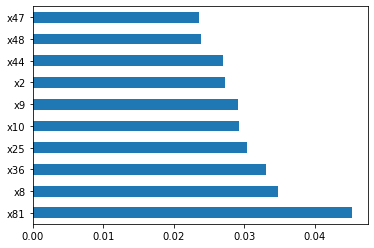

In [16]:
model = RandomForestClassifier(random_state=0)
model.fit(features,new_df['healthy'])
feat_importances = pd.Series(model.feature_importances_, index=features.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

## 4.2 correlation entre les feutures et la target

In [17]:
new_df.corrwith(new_df['healthy']).sort_values(ascending=False).head()

healthy    1.000000
x49        0.277275
x37        0.184847
x50        0.181490
x41        0.105527
dtype: float64

on remarque que les features ne sont pas corrélées avec la variable healthy

# 5. Visualisations

## 5.1 Categorical features visualisation

#### b. x80 variable

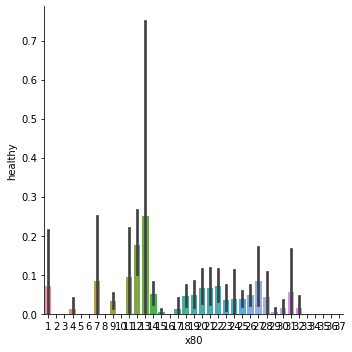

In [18]:
sns.catplot(x="x80", y="healthy", kind="bar", data=fd)

on reamrque que l'intervalle de confiance du variable time est trop grand

## 5.2 numerical variables

malgré la reduction d'un nombre important de variable mais il y a toujours 53 variables ce qui est difficile pour la visualisation. c'est pour cela , on va utiliser la PCA pour reduire la dimension de ce jeu de données

In [19]:
cat = ['Company', 'x80', 'Financial Distress' ]
num = [x for x in new_df.columns if x not in cat]
num_features = new_df[num] 
num_features.head()

,x8,x9,x10,x12,x15,x18,x19,x20,x21,x22,...,x71,x72,x73,x74,x78,x79,x81,x82,x83,healthy
0,0.018854,0.182790,0.006449,2.00580,4.6512,0.018265,0.024978,0.027264,1.41730,9.5554,...,61.476,4.0,36.0,85.437,16.0,0.2,0.060390,30,49,0
1,0.006423,0.035991,0.001795,-0.48644,3.7521,0.027558,0.028804,0.041102,1.18010,7.2952,...,24.579,0.0,36.0,107.090,16.0,0.4,0.010636,31,50,0
2,-0.081423,-0.765400,-0.054324,0.41220,2.4884,0.012595,0.068116,0.014847,0.81652,7.1204,...,20.700,0.0,35.0,120.870,15.0,-0.2,-0.455970,32,51,0
3,-0.018807,-0.107910,-0.065316,0.99490,1.6382,0.011601,0.094385,0.014415,0.90391,7.9828,...,47.429,4.0,33.0,54.806,16.0,5.6,-0.325390,33,52,1
4,0.128030,0.577250,0.094075,3.01470,1.6169,0.006814,0.079346,0.008876,1.02510,4.7463,...,61.476,4.0,36.0,85.437,16.0,0.2,1.251000,7,27,0


Text(0, 0.5, 'Cumulative explained variance')

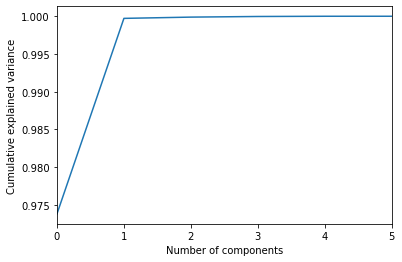

In [20]:
pca = PCA().fit(num_features)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,5,1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

on reamrque plus de 100% de l'information est contenue dans les 2 premieres composantes

In [21]:
# scaling data

scaler = StandardScaler()
scaler.fit(num_features)
scaled_data = scaler.transform(num_features)

# applying Principal component analysis
pca = PCA(n_components=2)
pca.fit(scaled_data)
x_pca = pca.transform(scaled_data)

print("le volume du dataset original : ",scaled_data.shape)
print("le volume du dataset reduit :", x_pca.shape)

le volume du dataset original :  (3672, 52)
le volume du dataset reduit : (3672, 2)


Text(0, 0.5, 'Second Principal Component')

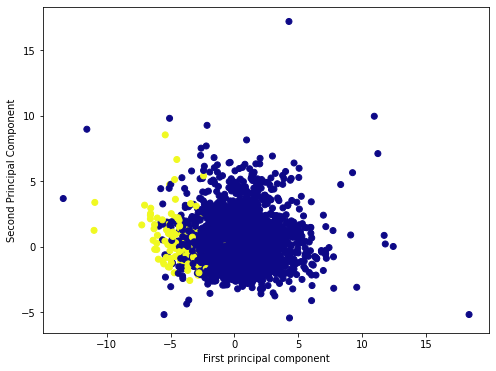

In [22]:


plt.figure(figsize=(8,6))
plt.scatter(x_pca[:,0],x_pca[:,1],c=fd['healthy'],cmap='plasma')
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')


on remarque que le dataset est trés déséquilibré

In [23]:
df_comp = pd.DataFrame(pca.components_,columns=num)

<AxesSubplot:>

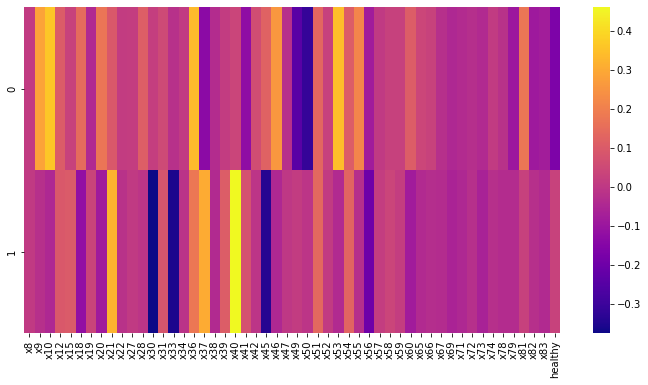

In [24]:
plt.figure(figsize=(12,6))
sns.heatmap(df_comp,cmap='plasma',)

on remaque que : <br>
    - x50 qui a le plus d'impact le plus d'impact sur la composante 0 <br>
    - x30, x33 et x40 ont le plus d'impact sur la composnate 1
    <br>
 c'est pour cela on se contantera de visualiser  ces variables

#### a. x50 <br>
plot of the x50 distribution of companies who are healthy and not healthy

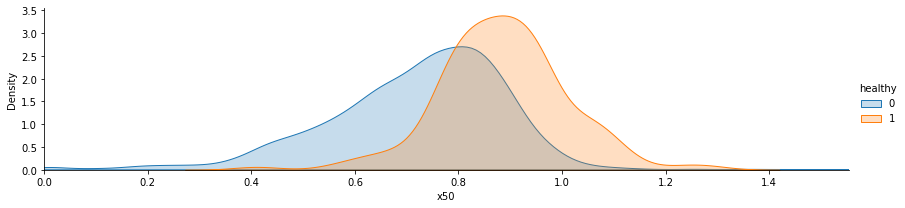

In [25]:
plot_distribution( new_df , var = 'x50' , target = 'healthy' , row = None )

#### b. x30 <br>
plot of the x30 distribution of companies who are healthy and not healthy


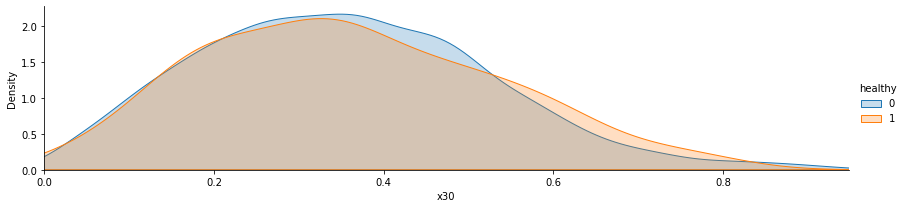

In [26]:
plot_distribution( new_df , var = 'x30' , target = 'healthy' , row = None )

#### b. x40 <br>
plot of the x40 distribution of companies who are healthy and not healthy

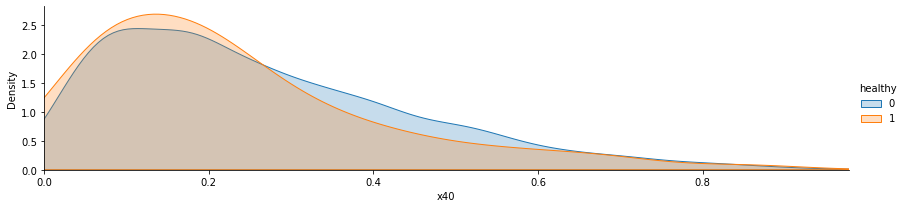

In [27]:
plot_distribution( new_df , var = 'x40' , target = 'healthy' , row = None )

#### c. x33 <br>
plot of the x33 distribution of companies who are healthy and not healthy

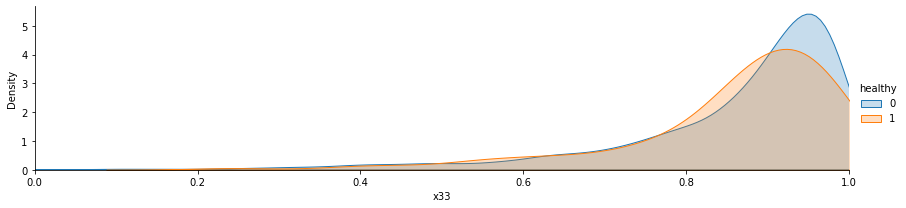

In [28]:
plot_distribution( new_df , var = 'x33' , target = 'healthy' , row = None )

# 6. features engineering

## 6.1 spliting and resempling data

on va utiliser le knn classifier pour tester quelle methode du resampling est la plus convenable à notre dataset

on va séparer notre data car l'objectif principale est de la tester sur les données originales et non pas les données crées par la technique de resampling qu'on va choisir ensuite puis on va faire du feature engineering sur le train et le test set separément

In [29]:
X = new_df.drop('healthy', axis = 1)
y = new_df['healthy']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)
model = KNeighborsClassifier(n_neighbors=3)
res_x = []
res_y =[]
for x in range(4) :
    res_x.append(x_train)
    res_y.append(y_train)

## 6.2 Choix de la methode de resampling

### 6.2.1 Undersampling

In [30]:
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('under', under), ('model', model)]
pipeline = Pipeline(steps=steps)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, res_x[0], res_y[0], scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.624


### 6.2.2 Oversampling

In [31]:
over = RandomOverSampler(sampling_strategy=0.5)
steps = [('over', over),('model', model)]
pipeline = Pipeline(steps=steps)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, res_x[1], res_y[1], scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.540


### 6.2.3 SMOTE

In [32]:
smote = SMOTE(sampling_strategy=0.1)
steps = [('smote', smote),('model', model)]
pipeline = Pipeline(steps=steps)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, res_x[2], res_y[2], scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.557


### 6.2.4 SMOTE suivi par le undersampling

In [33]:
smote = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('smote', smote),('under', under),('model', model)]
pipeline = Pipeline(steps=steps)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, res_x[3], res_y[3], scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.623


dans notre cas on remarque que le smote suivi par undersampling qui a la meuilleure performance mais d'aprés nos recherches , il es plus convenable de faire du features engineering avant le resampling

In [34]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)
smote = SMOTE(sampling_strategy=0.2)
under = RandomUnderSampler(sampling_strategy=0.6)
x_train, y_train = smote.fit_resample(x_train, y_train)
x_train,y_train=under.fit_resample(x_train,y_train)

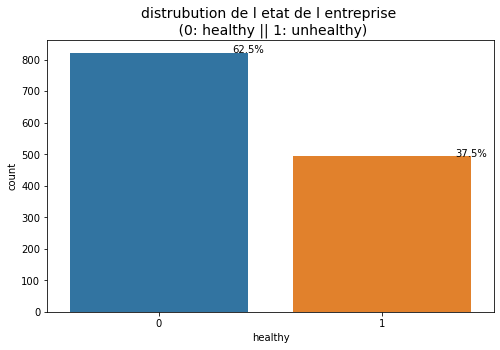

In [35]:
total = float(len(x_train))
plt.figure(figsize=(8,5))
ax = sns.countplot(x = y_train, data=x_train)
plt.title('distrubution de l etat de l entreprise \n (0: healthy || 1: unhealthy)', fontsize=14)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='center')

plt.show()

# 7. Choix de l'algorithme

## 7.1 logistic regression

In [36]:
LR_clf = LogisticRegression()
LR_clf.fit(x_train, y_train)
print('Accuracy of Logistic regression classifier on training set: {:.2f}'
     .format(LR_clf.score(x_train, y_train)))
print('Accuracy of Logistic regression classifier on test set: {:.2f}'
     .format(LR_clf.score(x_test, y_test)))

Accuracy of Logistic regression classifier on training set: 0.68
Accuracy of Logistic regression classifier on test set: 0.80


<AxesSubplot:>

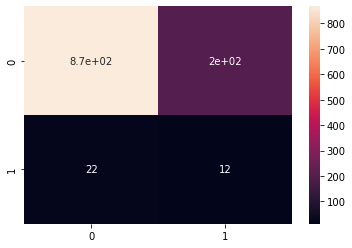

In [37]:
y_pred = LR_clf.predict(x_test)
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True)

In [38]:
pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T

,precision,recall,f1-score,support
0,0.975253,0.811798,0.886050,1068.000000
1,0.056338,0.352941,0.097166,34.000000
accuracy,0.797641,0.797641,0.797641,0.797641
macro avg,0.515796,0.582369,0.491608,1102.000000
weighted avg,0.946902,0.797641,0.861711,1102.000000


## 7.2 KNN

In [39]:
knn_pipe = make_pipeline(StandardScaler(), KNeighborsClassifier())
param_grid = {'kneighborsclassifier__n_neighbors': range(1, 10)}
grid = GridSearchCV(knn_pipe, param_grid, cv=10, scoring='accuracy')
grid_search=grid.fit(x_train, y_train)

In [40]:

print(grid.best_params_)
print(grid.score(x_test, y_test))

{'kneighborsclassifier__n_neighbors': 2}
0.9292196007259528


<AxesSubplot:>

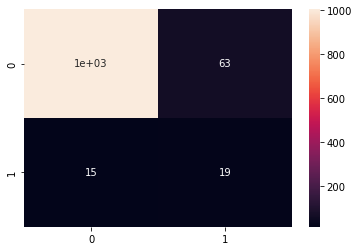

In [41]:
y_pred = grid.predict(x_test)
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True)

In [42]:
pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T

,precision,recall,f1-score,support
0,0.985294,0.941011,0.962644,1068.00000
1,0.231707,0.558824,0.327586,34.00000
accuracy,0.929220,0.929220,0.929220,0.92922
macro avg,0.608501,0.749917,0.645115,1102.00000
weighted avg,0.962044,0.929220,0.943050,1102.00000


## 7.3 SVC

In [43]:
svc_pipe = make_pipeline(StandardScaler(), SVC(kernel = 'linear', C = 1.0, random_state = 0))
svc_pipe.fit(x_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(kernel='linear', random_state=0))])

<AxesSubplot:>

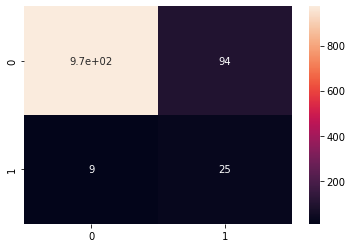

In [44]:
y_pred_svm= svc_pipe.predict(x_test)
cf_matrix = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cf_matrix, annot=True)

In [45]:
pd.DataFrame(classification_report(y_test, y_pred_svm, output_dict=True)).T

,precision,recall,f1-score,support
0,0.990844,0.911985,0.949781,1068.000000
1,0.210084,0.735294,0.326797,34.000000
accuracy,0.906534,0.906534,0.906534,0.906534
macro avg,0.600464,0.823640,0.638289,1102.000000
weighted avg,0.966756,0.906534,0.930560,1102.000000


## 7.4 Decision tree classifier

In [46]:
param_grid = { 'criterion':['gini','entropy'],'max_depth': np.arange(3, 15)}
dtree_model=DecisionTreeClassifier()
dtree_gscv = GridSearchCV(dtree_model, param_grid, cv=5)
dtree_gscv.fit(x_train, y_train)
dtree_gscv.best_params_

{'criterion': 'entropy', 'max_depth': 11}

In [47]:
dtree_gscv.score(x_test, y_test)

0.9128856624319419

<AxesSubplot:>

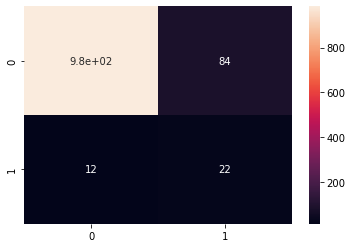

In [48]:
y_pred = dtree_gscv.predict(x_test)
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True)

In [49]:
pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T

,precision,recall,f1-score,support
0,0.987952,0.921348,0.953488,1068.000000
1,0.207547,0.647059,0.314286,34.000000
accuracy,0.912886,0.912886,0.912886,0.912886
macro avg,0.597749,0.784204,0.633887,1102.000000
weighted avg,0.963874,0.912886,0.933767,1102.000000


## 7.5 Random forest classifer

<AxesSubplot:>

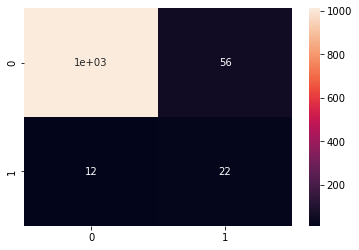

In [50]:
forest = RandomForestClassifier(criterion = 'entropy'
                                , n_estimators = 10
                                , random_state = 1
                                , n_jobs = 1)

forest.fit(x_train, y_train)
y_pred = forest.predict(x_test)
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True)

In [51]:
pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T

,precision,recall,f1-score,support
0,0.988281,0.947566,0.967495,1068.000000
1,0.282051,0.647059,0.392857,34.000000
accuracy,0.938294,0.938294,0.938294,0.938294
macro avg,0.635166,0.797312,0.680176,1102.000000
weighted avg,0.966492,0.938294,0.949766,1102.000000


on remarque que le random forest classifier qui a un recall, f1-score et une presicion maximale mais les resultats restent tres insuffisants et malgré tout les efforts(cross_validation, gridsearchcv, resampling, .. ) pour ameliorer les autres metrics pour la classe minoritaire.